In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

/Users/colladete/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Before starting the Kernel, I want to thank these two kernels from Kaggle, where I learned some of the techniques I will be using:

1. [Pythanic](https://www.kaggle.com/headsortails/pytanic)
2. [Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)

In [2]:
train_df = pd.read_csv('train titanic.csv')
test_df = pd.read_csv('test titanic.csv')

We won't be needing **'PassengerId'**. Let's drop it. 

In [3]:
train_df.drop(['PassengerId'], 1, inplace=True)
test_df.drop(['PassengerId'], 1, inplace=True)

In [4]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Engineering

I am going to dig into each of the features and analyze what we can get from them. As a first step, I will start with **'Ticket'**.

I am going to check for every passenger whether their ticket is unique or if they are sharing it with other passengers. 

In [5]:
ticketgrouptrain = train_df.groupby('Ticket').size().reset_index()
ticketgrouptest = test_df.groupby('Ticket').size().reset_index()
ticketgrouptrain.rename(columns = {0: 'Count'}, inplace=True)
ticketgrouptest.rename(columns = {0: 'Count'}, inplace=True)

for i in range(0,train_df.shape[0]):
    train_df.ix[i, 'Sharedticket'] = ticketgrouptrain.Count[ticketgrouptrain.Ticket == train_df.Ticket[i]].item()
for i in range(0,test_df.shape[0]):
    test_df.ix[i, 'Sharedticket'] = ticketgrouptest.Count[ticketgrouptest.Ticket == test_df.Ticket[i]].item()   

train_df.drop('Ticket', 1, inplace=True)
test_df.drop('Ticket', 1, inplace=True)   

In [ ]:
train_df.head()

Let's visualize it to see the impact on the survival rate. 

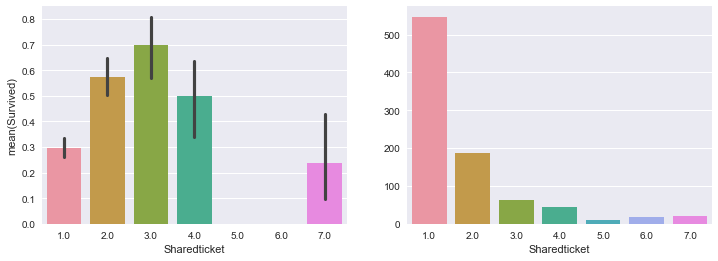

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.barplot(x='Sharedticket', y = 'Survived', data = train_df, ax = axs[0])
sns.barplot(x=train_df.groupby('Sharedticket').size().index, y = train_df.groupby('Sharedticket').size().values, ax = axs[1])

I am going to try to reduce index values to see if we can a more concise result.

In [7]:
train_df['Sharedticket2'] = train_df.Sharedticket
train_df.Sharedticket2[(train_df.Sharedticket2 == 2.0) | (train_df.Sharedticket2 == 3.0)  | 
                      (train_df.Sharedticket2 == 4.0) ] = 2
train_df.Sharedticket2[(train_df.Sharedticket2 == 5.0) | (train_df.Sharedticket2 == 6.0) | 
                       (train_df.Sharedticket2 == 7.0)] = 3

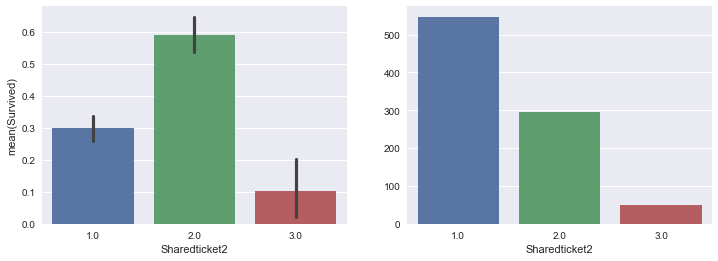

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.barplot(x='Sharedticket2', y = 'Survived', data = train_df, ax = axs[0])
sns.barplot(x=train_df.groupby('Sharedticket2').size().index, y = train_df.groupby('Sharedticket2').size().values, ax = axs[1])

In [9]:
train_df.Sharedticket[train_df.Sharedticket == 1] = 'Not shared'
train_df.Sharedticket[(train_df.Sharedticket == 2.0) | (train_df.Sharedticket == 3.0)  | 
                      (train_df.Sharedticket == 4.0) ] = 'Shared small'
train_df.Sharedticket[(train_df.Sharedticket == 5.0) | (train_df.Sharedticket == 6.0) | 
                       (train_df.Sharedticket == 7.0)] = 'Shared big'
test_df.Sharedticket[test_df.Sharedticket == 1] = 'Not shared'
test_df.Sharedticket[(test_df.Sharedticket == 2.0) | (test_df.Sharedticket == 3.0)  | 
                      (test_df.Sharedticket == 4.0) ] = 'Shared small'
test_df.Sharedticket[(test_df.Sharedticket == 5.0) | (test_df.Sharedticket == 6.0) | 
                       (test_df.Sharedticket == 7.0)] = 'Shared big'
train_df.drop('Sharedticket2', 1, inplace=True)

Let's continue with the **siblings/spouses** and **parents/childrens** features. I am going to add them together and then split the whole dataset into passengers traveling alone, those traveling with small families, and those traveling with big families. It does seem to make an impact. 

In [10]:
train_df['Family'] = train_df['SibSp'] + train_df['Parch']
test_df['Family'] = test_df['SibSp'] + test_df['Parch']

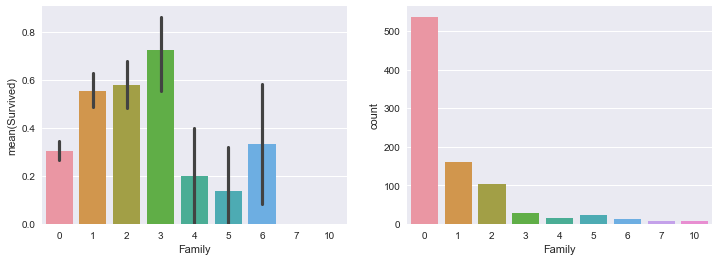

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.barplot(x='Family', y = 'Survived', data = train_df, ax = axs[0])
sns.countplot(train_df['Family'], ax = axs[1])

In [12]:
for i in range(0, train_df.shape[0]):
    if train_df.Family[i] == 0:
        train_df.ix[i, 'Familytype'] = 'Alone'
    elif (train_df.Family[i] > 0) & (train_df.Family[i] < 4):
        train_df.ix[i, 'Familytype'] = 'Small family'
    else:
        train_df.ix[i, 'Familytype'] = 'Big family'

for i in range(0, test_df.shape[0]):
    if test_df.Family[i] == 0:
        test_df.ix[i, 'Familytype'] = 'Alone'
    elif (test_df.Family[i] > 0) & (test_df.Family[i] < 4):
        test_df.ix[i, 'Familytype'] = 'Small family'
    else:
        test_df.ix[i, 'Familytype'] = 'Big family'   
        
train_df.drop(['SibSp', 'Parch', 'Family'], 1, inplace=True)
test_df.drop(['SibSp', 'Parch', 'Family'], 1, inplace=True) 

I want to check how correlated this feature is with 'Sharedticket'. As you can see below, they clearly are related, but not as much as I expected. For the time being I am going to keep both. 

In [13]:
tab = pd.crosstab(train_df['Sharedticket'], train_df['Familytype'])
print(tab)

Familytype    Alone  Big family  Small family
Sharedticket                                 
Not shared      462           2            83
Shared big        9          37             3
Shared small     66          23           206


In [ ]:
train_df.head()

Now let's move to **'Embarked'**. Before starting, there are two missing entries in the train dataset. We see that the Fare for both entries is really high. I am going to plot to see the typical fare of each port and then decide. 

In [14]:
train_df[train_df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,Sharedticket,Familytype
61,1,1,"Icard, Miss. Amelie",female,38.0,80.0,B28,NaN,Shared small,Alone
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,80.0,B28,NaN,Shared small,Alone


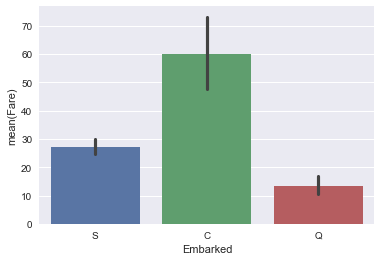

In [15]:
sns.barplot(x='Embarked', y ='Fare', data= train_df)

In [16]:
train_df.Embarked[train_df.Embarked.isnull()] = 'C'

'C' seems like a good guess. In the plot below we see that Embarked can be a good feature as is, so I am not going to touch it. 

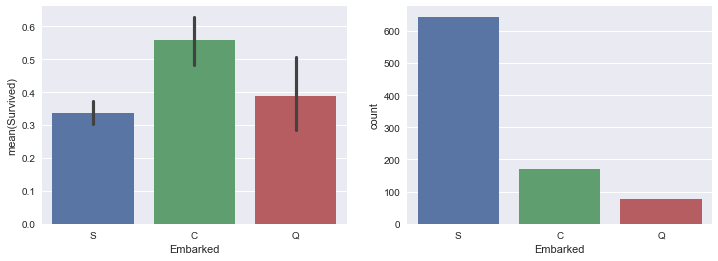

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.barplot(x='Embarked', y = 'Survived', data = train_df, ax = axs[0])
sns.countplot(train_df['Embarked'], ax = axs[1])

What about **'Cabin'**? This is the feature with more NA values, so many that normally we would do good by dropping it. But in this case, the fact that there are missing values might be more related to the target than expected, because missing information can be connected to not survivals. 

Let's see.

In [ ]:
train_df.head()

In [18]:
train_df.Cabin[train_df.Cabin.isnull()] = 'Z'
train_df.Cabin = [x[0] for x in train_df.Cabin]
test_df.Cabin[test_df.Cabin.isnull()] = 'Z'
test_df.Cabin = [x[0] for x in test_df.Cabin]

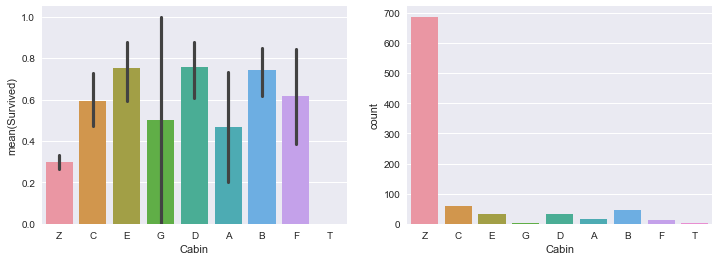

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.barplot(x='Cabin', y = 'Survived', data = train_df, ax = axs[0])
sns.countplot(train_df['Cabin'], ax = axs[1])

We confirm in the plot that the missing info does impact the survival rate. I am only going to keep whether they had the Cabin or not. 

In [20]:
train_df.ix[(train_df.Cabin != 'Z'), 'Cabinknown'] = 'Yes'
train_df.ix[(train_df.Cabin == 'Z'), 'Cabinknown'] = 'No'
test_df.ix[(test_df.Cabin != 'Z'), 'Cabinknown'] = 'Yes'
test_df.ix[(test_df.Cabin == 'Z'), 'Cabinknown'] = 'No'
train_df.drop('Cabin', 1, inplace=True)
test_df.drop('Cabin', 1, inplace=True)

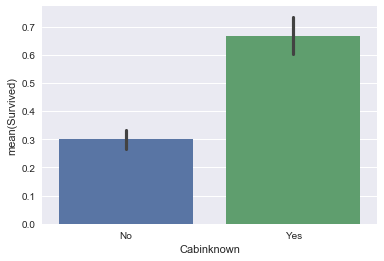

In [21]:
sns.barplot(x='Cabinknown', y = 'Survived', data = train_df)

In [ ]:
train_df.head()

Let's move on to the **'Fare'** feature. Before anything, there is a missing value in the test dataset. I am going to calculate the mean of the Fare for the entries with the same port and 'Pclass'. 

In [22]:
test_df[test_df.Fare.isnull()]
train_df.Fare[(train_df['Pclass'] == 3) & (train_df['Embarked'] == 'S')].mean()
test_df.Fare[test_df.Fare.isnull()] = 14.64

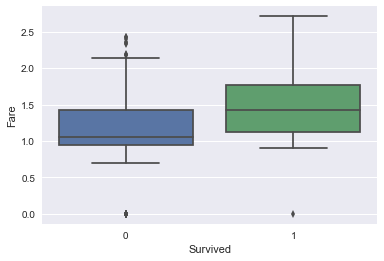

In [23]:
sns.boxplot(x=train_df.Survived, y= np.log10(train_df.Fare + 1))

In [27]:
train_df.ix[(train_df.Fare >= 70),'Fare'] = 3
train_df.ix[(train_df.Fare < 70),'Fare'] = 2
train_df.ix[(train_df.Fare <= 10),'Fare'] = 1
test_df.ix[(test_df.Fare >= 70),'Fare'] = 3
test_df.ix[(test_df.Fare < 70),'Fare'] = 2
test_df.ix[(test_df.Fare <= 10),'Fare'] = 1

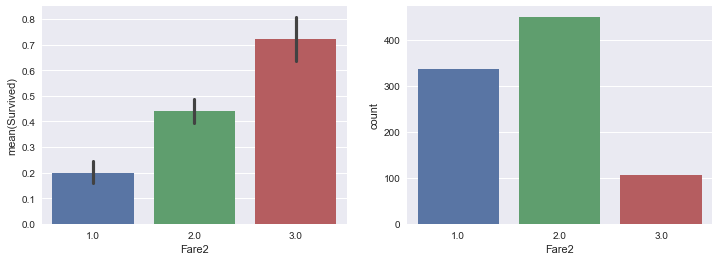

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.barplot(x='Fare2', y = 'Survived', data = train_df, ax = axs[0])
sns.countplot(x='Fare2', data = train_df, ax = axs[1])

In [29]:
train_df.drop('Fare', 1, inplace=True)
test_df.drop('Fare', 1, inplace=True)

In [30]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,Embarked,Sharedticket,Familytype,Cabinknown,Fare2
0,0,3,"Braund, Mr. Owen Harris",male,22.0,S,Not shared,Small family,No,1.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,C,Not shared,Small family,Yes,3.0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,S,Not shared,Alone,No,1.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,S,Shared small,Small family,Yes,2.0
4,0,3,"Allen, Mr. William Henry",male,35.0,S,Not shared,Alone,No,1.0


Now let's tackle the most interesting and unexpected feature: the **'Name'**. I am going to extract the titles of each passenger. As we will see, the title, mainly Master, will allow us to identify the male kids. I will as well move the weird titles to the most common ones. 

In [31]:
for i in range(0,train_df.shape[0]):
    train_df.ix[i, 'Title'] = re.search('([A-Za-z]+)\.', train_df.Name[i]).group(0)
for i in range(0,test_df.shape[0]):
    test_df.ix[i, 'Title'] = re.search('([A-Za-z]+)\.', test_df.Name[i]).group(0)

In [32]:
train_df.Title.value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Col.           2
Mlle.          2
Don.           1
Ms.            1
Lady.          1
Sir.           1
Jonkheer.      1
Countess.      1
Mme.           1
Capt.          1
Name: Title, dtype: int64

In [33]:
test_df.Title.value_counts()

Mr.        240
Miss.       78
Mrs.        72
Master.     21
Rev.         2
Col.         2
Ms.          1
Dona.        1
Dr.          1
Name: Title, dtype: int64

In [34]:
train_df.Title[(train_df.Title == 'Dr.') | (train_df.Title == 'Rev.') | (train_df.Title == 'Major.') | 
               (train_df.Title == 'Col.') | (train_df.Title == 'Sir.') | (train_df.Title == 'Don.') |
              (train_df.Title == 'Capt.') | (train_df.Title == 'Jonkheer.')] = 'Mr.'
train_df.Title[(train_df.Title == 'Mlle.') | (train_df.Title == 'Ms.') | (train_df.Title == 'Lady.')] = 'Miss.'
train_df.Title[(train_df.Title == 'Mme.') | (train_df.Title == 'Countess.')] = 'Mrs.'
test_df.Title[(test_df.Title == 'Col.') | (test_df.Title == 'Rev.') | (test_df.Title == 'Dr.')] = 'Mr.'
test_df.Title[(test_df.Title == 'Dona.')] = 'Mrs.'
test_df.Title[(test_df.Title == 'Ms.')] = 'Miss.'

In [35]:
train_df.Title.value_counts()

Mr.        538
Miss.      186
Mrs.       127
Master.     40
Name: Title, dtype: int64

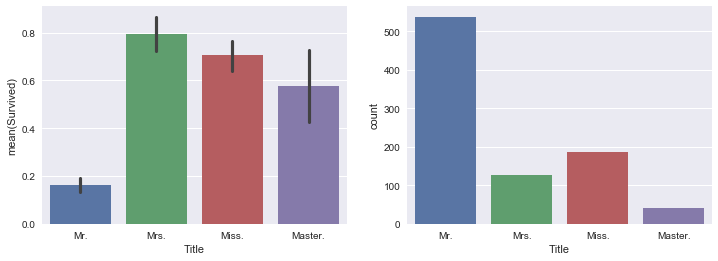

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.barplot(x='Title', y = 'Survived', data = train_df, ax = axs[0])
sns.countplot(train_df['Title'], ax = axs[1])

As you can see above. The females and Master (kids) have higher chances of surviving. Below I am going to plot the Age feature and, as we can see, apart from male children, it doesn't seem to be really related to survival rate. We might be doing well by keeping: male, child male and women. 

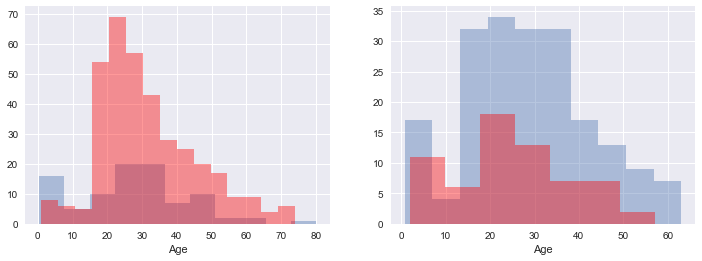

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.distplot(train_df.Age[-train_df.Age.isnull() & (train_df.Survived == 1) & (train_df.Sex == 'male')], kde = False, ax = axs[0])
sns.distplot(train_df.Age[-train_df.Age.isnull() & (train_df.Survived == 0) & (train_df.Sex == 'male')], color = 'red', kde = False, ax = axs[0])
sns.distplot(train_df.Age[-train_df.Age.isnull() & (train_df.Survived == 1) & (train_df.Sex == 'female')], kde = False, ax = axs[1])
sns.distplot(train_df.Age[-train_df.Age.isnull() & (train_df.Survived == 0) & (train_df.Sex == 'female')], color = 'red', kde = False, ax = axs[1])

In [38]:
train_df.Title[(train_df.Title == 'Miss.') | (train_df.Title == 'Mrs.')] = 'Woman'
test_df.Title[(test_df.Title == 'Miss.') | (test_df.Title == 'Mrs.')] = 'Woman'
train_df.rename(columns = {'Title': 'Person'}, inplace=True)
test_df.rename(columns = {'Title': 'Person'}, inplace=True)
train_df.drop(['Name', 'Sex'], 1, inplace=True)
test_df.drop(['Name', 'Sex'], 1, inplace=True)

With age, the only thing we might want to do is to create the same values we created for Cabin. Whether we know the age or not. 

In [39]:
train_df.ix[-np.isnan(train_df.Age), 'Ageknown'] = 'Yes'
train_df.ix[np.isnan(train_df.Age), 'Ageknown'] = 'No'
test_df.ix[-np.isnan(test_df.Age), 'Ageknown'] = 'Yes'
test_df.ix[np.isnan(test_df.Age), 'Ageknown'] = 'No'

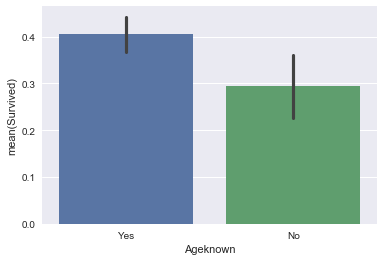

In [40]:
sns.barplot(x='Ageknown', y = 'Survived', data = train_df)

The last feature is **'Pclass'**, which clearly has a big impact. Below, as promised, I check whether Fare and Pclass are correlated. They do seem to be connected but, as you can see, belonging to one Pclass changes the survival rate for the same Fare. 

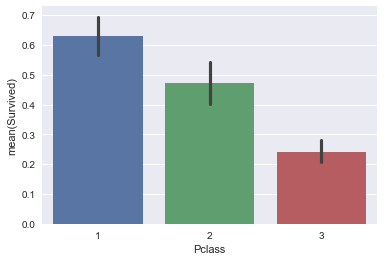

In [41]:
sns.barplot(x = 'Pclass', y = 'Survived', data = train_df)

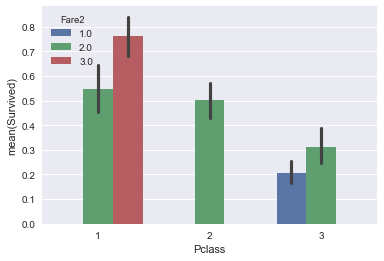

In [42]:
sns.barplot(x = 'Pclass', y = 'Survived', hue= 'Fare2', data = train_df)

### Machine learning

Now let's finalize the dataframe and get the dummies for the categorical values. 

In [45]:
col_names = ['Cabinknown', 'Embarked', 'Person', 'Ageknown', 'Sharedticket', 'Familytype']
train_df = pd.get_dummies(train_df, columns=col_names, drop_first=True)
test_df = pd.get_dummies(test_df, columns=col_names, drop_first=True)
train_df.drop('Age', 1, inplace=True)
test_df.drop('Age', 1, inplace=True)

In [74]:
train_df.head()

,Survived,Pclass,Fare2,Cabinknown_Yes,Embarked_Q,Embarked_S,Person_Mr.,Person_Woman,Ageknown_Yes,Sharedticket_Shared big,Sharedticket_Shared small,Familytype_Big family,Familytype_Small family
0,0,3,1.0,0,0,1,1,0,1,0,0,0,1
1,1,1,3.0,1,0,0,0,1,1,0,0,0,1
2,1,3,1.0,0,0,1,0,1,1,0,0,0,0
3,1,1,2.0,1,0,1,0,1,1,0,1,0,1
4,0,3,1.0,0,0,1,1,0,1,0,0,0,0


In [46]:
X = np.array(train_df.drop('Survived', 1))
y = np.array(train_df['Survived'])
testX = np.array(test_df)

Before using the **VotingClassifier** and the **StackingClassifier**, I am going to see how the individual algorithms perform. 

In [86]:
svcmod = SVC(C = 15, kernel = 'rbf', gamma = 0.2, probability= True)
svcmod.scores = cross_val_score(svcmod, X, y, cv=5)

knnmod = KNeighborsClassifier(n_neighbors= 21)
knnmod.scores = cross_val_score(knnmod, X, y, cv=5)

rfmod = RandomForestClassifier(n_estimators=100, max_features=10, max_depth=5)
rfmod.scores = cross_val_score(rfmod, X, y, cv=5)

xgbmod = xgb.XGBClassifier(learning_rate= 0.1, gamma = 0.8, max_depth= 3, min_child_weight=7, 
                           objective= 'binary:logistic', subsample=0.8, colsample_bytree=0.8, 
                           scale_pos_weight=1, n_estimators = 1000, nthread = -1)
xgbmod.scores = cross_val_score(xgbmod, X, y, cv=5)

etmod = ExtraTreesClassifier(n_estimators=300, max_features=6, max_depth=6)
etmod.scores = cross_val_score(etmod, X, y, cv=5)

admod = AdaBoostClassifier(n_estimators= 100, learning_rate= 0.1)
admod.scores = cross_val_score(admod, X, y, cv=5)

lr = LogisticRegression(C = 0.1)
lr.scores = cross_val_score(lr, X, y, cv=5)

for clf, label in zip([svcmod, knnmod, rfmod, xgbmod, etmod, admod, lr], 
                      ['SVC', 
                       'KNN', 
                       'Random Forest',
                       'XGB',
                       'ExtraTrees',
                       'AdaBoost']):
    print("%s Accuracy: %0.2f (+/- %0.2f)" %(label, clf.scores.mean(), clf.scores.std() * 2))

SVC Accuracy: 0.80 (+/- 0.06)
KNN Accuracy: 0.81 (+/- 0.03)
Random Forest Accuracy: 0.82 (+/- 0.05)
XGB Accuracy: 0.82 (+/- 0.05)
ExtraTrees Accuracy: 0.82 (+/- 0.04)
AdaBoost Accuracy: 0.83 (+/- 0.04)


In [87]:
votemod = VotingClassifier(estimators=[('xgb', xgbmod), ('et', etmod), ('knn', knnmod), 
                                       ('rf', rfmod), ('ad', admod)], 
                           weights = [2,1,2,1,1],
                           voting='soft')

submited_file = pd.read_csv('gptest.csv')

votemod.scores = cross_val_score(votemod, X, y, cv=5)
print(votemod.scores.mean())

0.827184145469


In [89]:
stcmod = StackingClassifier(classifiers=[svcmod, xgbmod, knnmod, etmod, admod, rfmod], meta_classifier=lr)
stcmod.scores = cross_val_score(stcmod, X, y, cv=5)
print(stcmod.scores.mean())

0.821597624218


In [81]:
predictionsfinal = votemod.predict(testX)

In [82]:
testfinal = pd.read_csv('test titanic.csv')

In [83]:
submit = pd.DataFrame({'PassengerId' : testfinal.loc[:,'PassengerId'],
                       'Survived': predictionsfinal})
submit.to_csv("topublish.csv", index=False)